In [1]:
using DrWatson
@quickactivate :SwARExperiments

In [5]:
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [3]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

## Switching AR

## Generate AR

In [4]:
seed = 2
n_samples = 5000
n_states = 2
ar_order = 2
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.1, 1.0, 10.0, 100.0, 1000.0], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

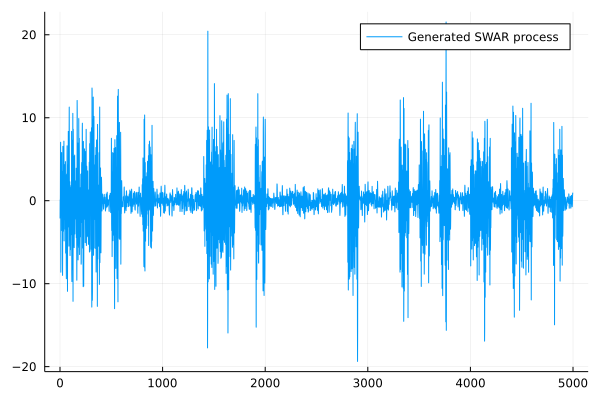

In [31]:
plot(outputs, label="Generated SWAR process")

In [32]:
plt_swar = @pgf Axis({
    title="Generated SWAR process",
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    xmin=0.0, xmax=5000,
    yminorgrids=true,
    tick_align="outside",
    scaled_y_ticks = false,
    xlabel=L"t", ylabel="value"
},
Plot({no_marks,color="orange"}, Coordinates(collect(1:length(outputs)), outputs)))

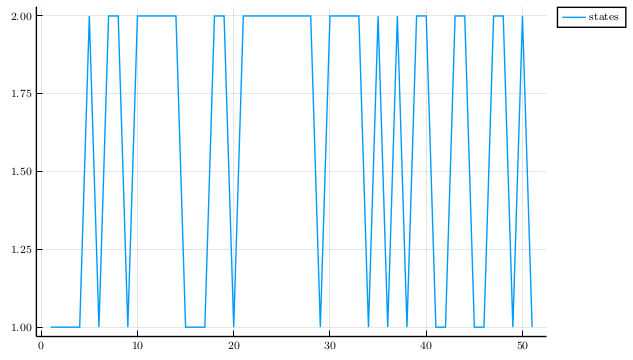

In [40]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

In [34]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    yminorgrids=true,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="8cm", height="5cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=1.5, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        ),
    ))

In [6]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

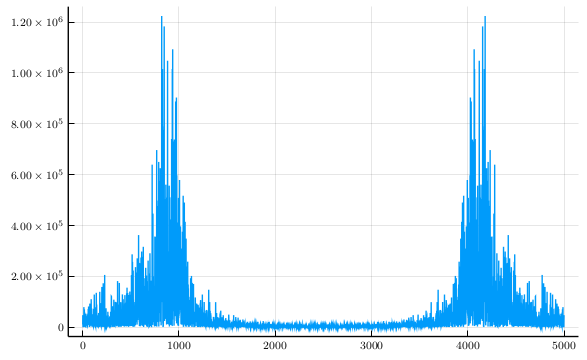

In [7]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

In [8]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

In [9]:
mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_swar(inputs, outputs, 50, 20, parameters);

Progress:  10%|████▏                                    |  ETA: 0:00:38

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [10]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.499912  0.499836
 0.500088  0.500164

In [11]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

In [12]:
mean.(mθs[end])

50-element Vector{Vector{Float64}}:
 [0.6673943241388962, -0.6329494042508385]
 [0.6960433098482971, -0.7406513719475816]
 [0.7775100604033804, -0.6560800106767364]
 [0.7304697032636315, -0.7709072472851279]
 [1.285406666787637, -0.6348912583662418]
 [0.9123271582362541, -0.6371427140970185]
 [1.3428908912581352, -0.6997027031556461]
 [1.3255974043399894, -0.6447592134094219]
 [0.7236837979875705, -0.636076715535218]
 [1.4021304832951447, -0.7863449411603596]
 ⋮
 [0.7623745168380344, -0.7093837831577574]
 [1.3297100238644424, -0.6990927755866324]
 [1.2979166748176367, -0.6795108465296]
 [0.6968483609143068, -0.7111321718278603]
 [0.6538576761084847, -0.6591666634060543]
 [1.3791292794426013, -0.7801894266725126]
 [1.3515122176516496, -0.6948708934768949]
 [0.692823687427914, -0.657552210932999]
 [1.3543183663079836, -0.7099261547092852]

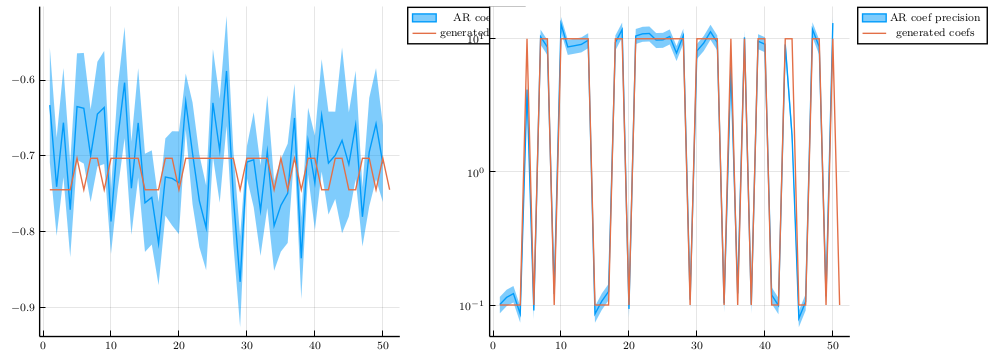

In [53]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 2
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

In [54]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .+  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .-  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


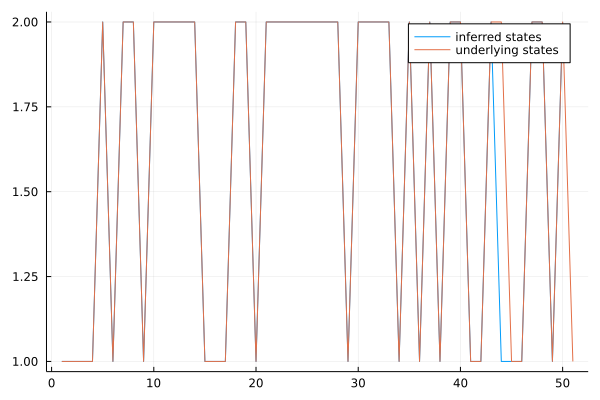

In [166]:
real_states = last.(findmax.(gen_states))
plot(round.(mean.(mzs[end][1:end])), label="inferred states")
plot!(real_states, label="underlying states")

In [ ]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    yminorgrids=true,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="8cm", height="5cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=1.5, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        ), LegendEntry("active state"),
    )

)

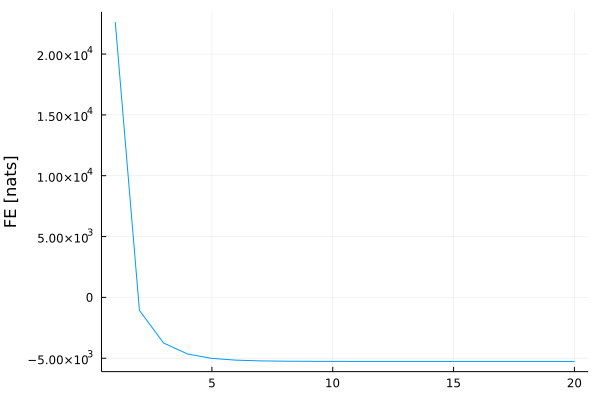

In [152]:
plot(mfe[1:end], label=:none, ylabel="FE [nats]")